In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit

In [6]:
import sys
sys.path.append('../src') 

In [12]:
from cnn_dl import GIDataset, mono_data_loader
from cnn_models import CNN_basic

In [7]:
from cnn_aux import files_list_npy_csv, select_image_and_lbl, get_energy, mean_rms

In [20]:
from cnn_plot import histoplot, plot_images,scatter_xyz, scatter_xyze
from cnn_plot import plot_images_ds, plot_loss, plotxyz, plotxyz_twoc
from cnn_eval import train_cnn, evaluate_cnn
from cnn_fit import fit_tdeltas, plotfxyz

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [14]:
data_dir = Path(os.environ['DATA'])
imgcsi = os.path.join(data_dir,"G4Prods/crystalGI", "CSIH1")
g4csi = os.path.join(data_dir,"G4Prods/crystalGI", "G4CSIH1")
imgbgo = os.path.join(data_dir,"G4Prods/crystalGI", "BGOH1")
g4bgo = os.path.join(data_dir,"G4Prods/crystalGI", "G4BGOH1")
fsp = "sensor_positions.csv"

# Setup

- CsI (Tl) crystal (50k phot/MeV)
- gammas interact uniformly in x,y and according to X0 in z

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- crystalGI simulation


## CNN run 1
- Use CNN_basic training only for (x,y,z), e.g, the first position of the gamma
- No normalization

In [10]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [15]:

datasetCSI = GIDataset(imgcsi, first_file, last_file,twoc=1) 


Running GIDataset with norm = False, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Loading images_0.npy, metadata_0.csv
Loading images_20.npy, metadata_20.csv
Loading images_40.npy, metadata_40.csv
Loading images_60.npy, metadata_60.csv
Loading images_80.npy, metadata_80.csv


In [16]:
datasetBGO = GIDataset(imgbgo, first_file, last_file,twoc=1) 


Running GIDataset with norm = False, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Loading images_0.npy, metadata_0.csv
Loading images_20.npy, metadata_20.csv
Loading images_40.npy, metadata_40.csv
Loading images_60.npy, metadata_60.csv
Loading images_80.npy, metadata_80.csv


In [17]:
data_loaderCSI, train_loaderCSI, val_loaderCSI, test_loaderCSI = mono_data_loader(datasetCSI, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 676848 events
 train size = 473793
 val size = 135369
 test size = 67686
 train indices = range(0, 473793)
 val indices = range(473793, 609162)
 test indices = range(609162, 676848)
473793 training events (69.99991135380469%)
135369 validation events (19.999911353804695%)
67686 test events (10.00017729239061%)


In [18]:
data_loaderBGO, train_loaderBGO, val_loaderBGO, test_loaderBGO = mono_data_loader(datasetBGO, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1320177 events
 train size = 924123
 val size = 264035
 test size = 132019
 train indices = range(0, 924123)
 val indices = range(924123, 1188158)
 test indices = range(1188158, 1320177)
924123 training events (69.99993182732315%)
264035 validation events (19.999969701032512%)
132019 test events (10.000098471644332%)


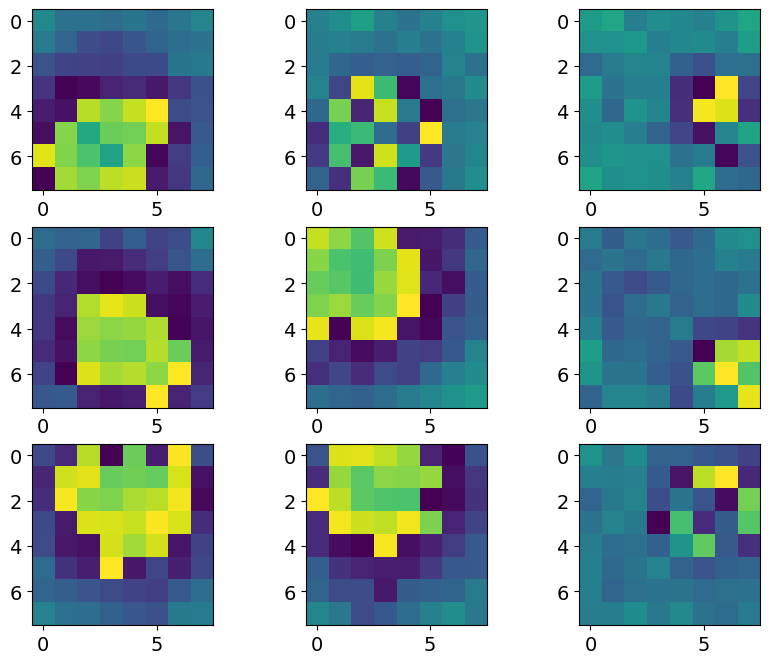

In [21]:
plot_images_ds(datasetCSI, imgs=(0,9), sx=3, figsize=(10, 8))

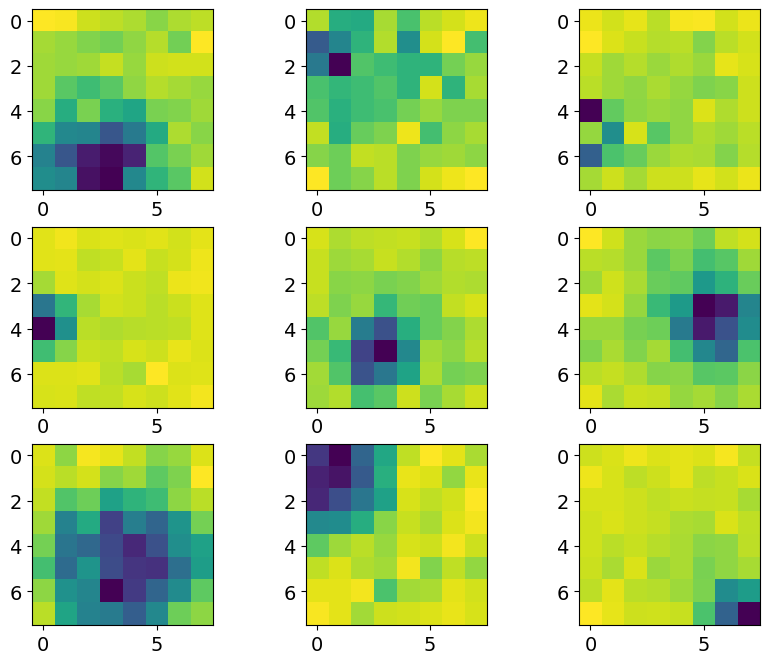

In [22]:
plot_images_ds(datasetBGO, imgs=(0,9), sx=3, figsize=(10, 8))

In [23]:
for images, positions in train_loaderCSI:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 6])
tensor([[128., 127., 162., 169., 194., 161., 173., 171.],
        [132., 165., 205., 197., 223., 230., 188., 203.],
        [131., 195., 202., 209., 260., 215., 237., 205.],
        [163., 201., 218., 242., 269., 255., 284., 253.],
        [178., 225., 244., 291., 311., 334., 305., 251.],
        [178., 199., 272., 300., 289., 324., 299., 291.],
        [172., 190., 229., 251., 301., 334., 299., 286.],
        [144., 185., 234., 247., 263., 284., 278., 270.]])


In [24]:
for images, positions in train_loaderBGO:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 6])
tensor([[ 19.,  28.,  27.,  31.,  31.,  32.,  26.,  24.],
        [ 33.,  39.,  37.,  45.,  33.,  31.,  29.,  21.],
        [ 18.,  33.,  39.,  33.,  49.,  39.,  43.,  35.],
        [ 26.,  27.,  37.,  45.,  43.,  43.,  35.,  34.],
        [ 23.,  24.,  35.,  58.,  63.,  60.,  59.,  53.],
        [ 39.,  34.,  26.,  69., 106.,  94.,  79.,  60.],
        [ 28.,  41.,  46.,  75., 114., 131.,  95.,  68.],
        [ 37.,  26.,  53.,  75.,  92., 105.,  98.,  50.]])


In [31]:
model = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, twoc=1).to(device)

In [32]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [34]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->474000 images
size of train loader  ->474 images
Evaluating with  ->136000 images
size of eval loader  ->136 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 13.331429056980438
--- EPOCH 0 AVG VAL LOSS: 13.018970847129822

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 12.789871847579247
--- EPOCH 1 AVG VAL LOSS: 12.361193229170407

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 12.454820707377502
--- EPOCH 2 AVG VAL LOSS: 11.860479628338533

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 12.219252354988067
--- EPOCH 3 AVG VAL LOSS: 11.936811496229733

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 12.044158168985874
--- EPOCH 4 AVG VAL LOSS: 11.42874599905575

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 11.924729805958423
--- EPOCH 5 AVG VAL LOSS: 11.662624807918773

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 11.802881560748137
--- EPOCH 6 AVG VAL LOSS: 11.628313597510843

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 11.705023781659733
--- EPOCH 7 AVG VAL LOSS: 11.538094394347247

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS:

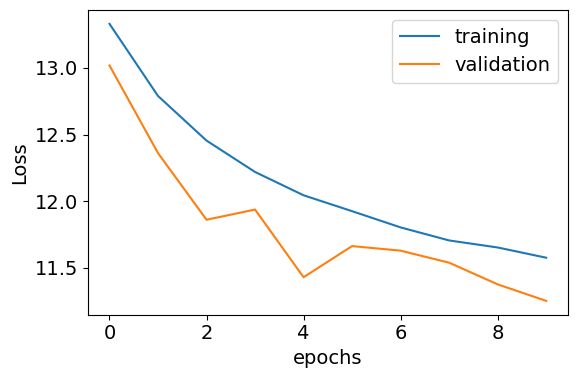

In [35]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [36]:
tdeltas = evaluate_cnn(test_loader, model, device, twoc=1)

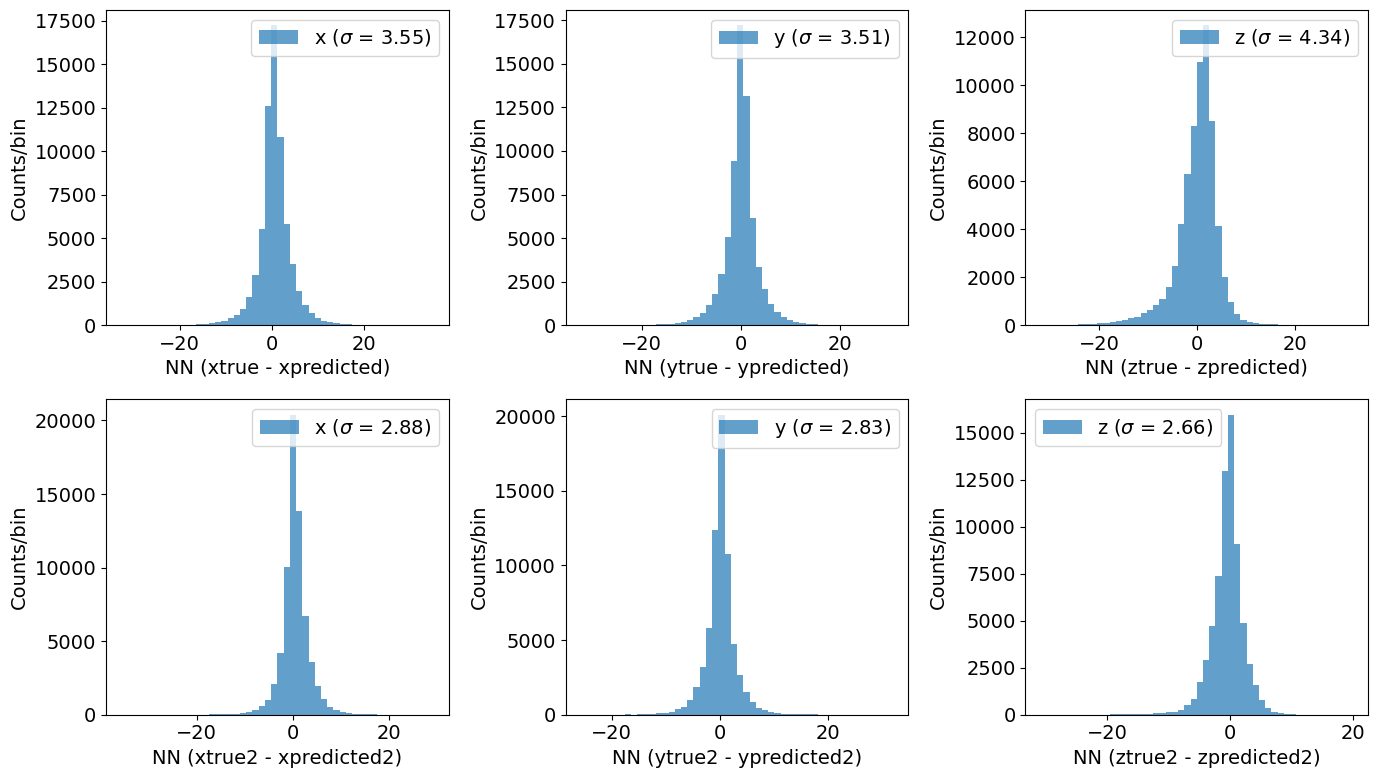

In [37]:
plotxyz_twoc(tdeltas, nbins=50)

In [38]:
f2gz, f2gx, f2gy, f2gz2, f2gx2, f2gy2 = fit_tdeltas(tdeltas, bins=100, twoc=1)

2g fit: mu1 = 1.00, sigma = 2.27, n1  =0.84
2g fit: mu2 = -1.00, sigma = 5.81, n1  =0.16
weighted error: = 2.85
2g fit: mu1 = 0.88, sigma = 3.44, n1  =0.36
2g fit: mu2 = 0.33, sigma = 1.11, n1  =0.64
weighted error: = 1.96
2g fit: mu1 = -0.05, sigma = 3.40, n1  =0.34
2g fit: mu2 = 0.15, sigma = 0.98, n1  =0.66
weighted error: = 1.80
2g fit: mu1 = -0.05, sigma = 0.76, n1  =0.55
2g fit: mu2 = -0.38, sigma = 2.58, n1  =0.45
weighted error: = 1.58
2g fit: mu1 = 0.60, sigma = 2.84, n1  =0.35
2g fit: mu2 = 0.17, sigma = 0.89, n1  =0.65
weighted error: = 1.57
2g fit: mu1 = 0.24, sigma = 0.81, n1  =0.67
2g fit: mu2 = 0.10, sigma = 2.77, n1  =0.33
weighted error: = 1.45


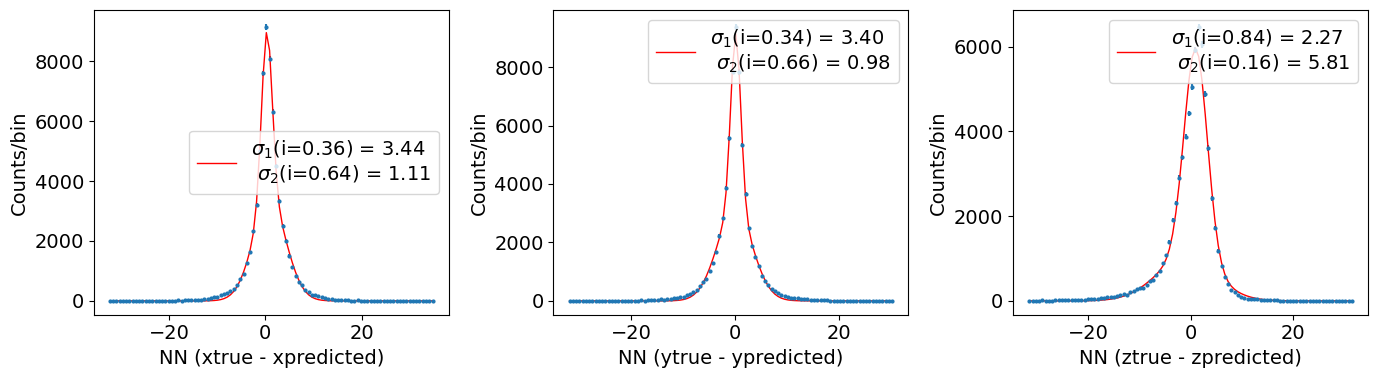

In [39]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

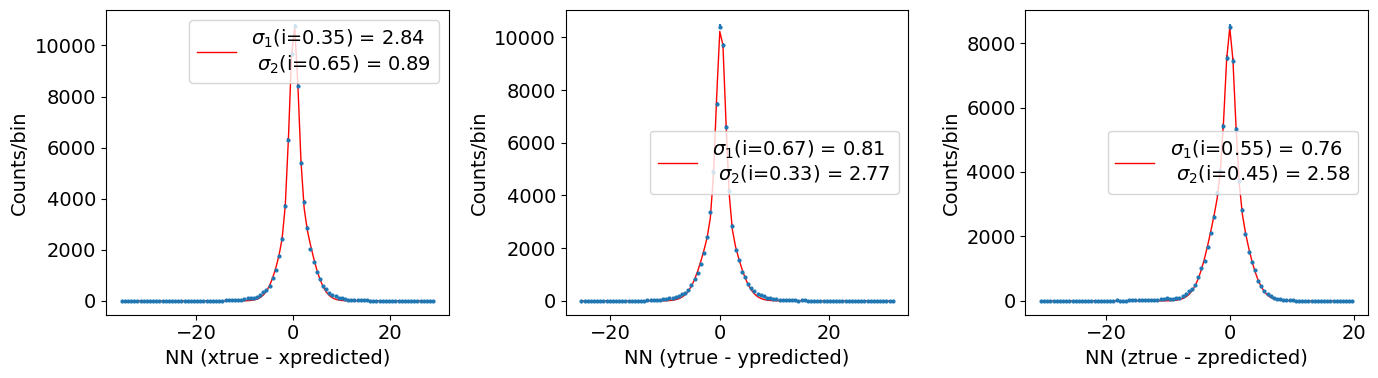

In [40]:
plotfxyz(f2gx2, f2gy2, f2gz2, figsize=(14, 4))

### Save model

In [41]:
torch.save(model.state_dict(), 'cnn_2c_csi.pth')

### Reload model

In [25]:
modelCSI = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, twoc=1).to(device)

In [26]:
modelCSI.load_state_dict(torch.load('cnn_2c_csi.pth'))

<All keys matched successfully>

In [27]:
modelBGO = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, twoc=1).to(device)
modelBGO.load_state_dict(torch.load('cnn_2c_bgo.pth'))

<All keys matched successfully>

In [29]:
tdeltasCSI = evaluate_cnn(test_loaderCSI, modelCSI, device, twoc=1)

input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 6])


In [32]:
cf2gz1, cf2gx1, cf2gy1, cf2gz2, cf2gx2, cf2gy2 = fit_tdeltas(tdeltasCSI, bins=100, twoc=1)

2g fit: mu1 = 1.00, sigma = 2.27, n1  =0.84
2g fit: mu2 = -1.00, sigma = 5.81, n1  =0.16
weighted error: = 2.85
2g fit: mu1 = 0.88, sigma = 3.44, n1  =0.36
2g fit: mu2 = 0.33, sigma = 1.11, n1  =0.64
weighted error: = 1.96
2g fit: mu1 = -0.05, sigma = 3.40, n1  =0.34
2g fit: mu2 = 0.15, sigma = 0.98, n1  =0.66
weighted error: = 1.80
2g fit: mu1 = -0.05, sigma = 0.76, n1  =0.55
2g fit: mu2 = -0.38, sigma = 2.58, n1  =0.45
weighted error: = 1.58
2g fit: mu1 = 0.60, sigma = 2.84, n1  =0.35
2g fit: mu2 = 0.17, sigma = 0.89, n1  =0.65
weighted error: = 1.57
2g fit: mu1 = 0.24, sigma = 0.81, n1  =0.67
2g fit: mu2 = 0.10, sigma = 2.77, n1  =0.33
weighted error: = 1.45


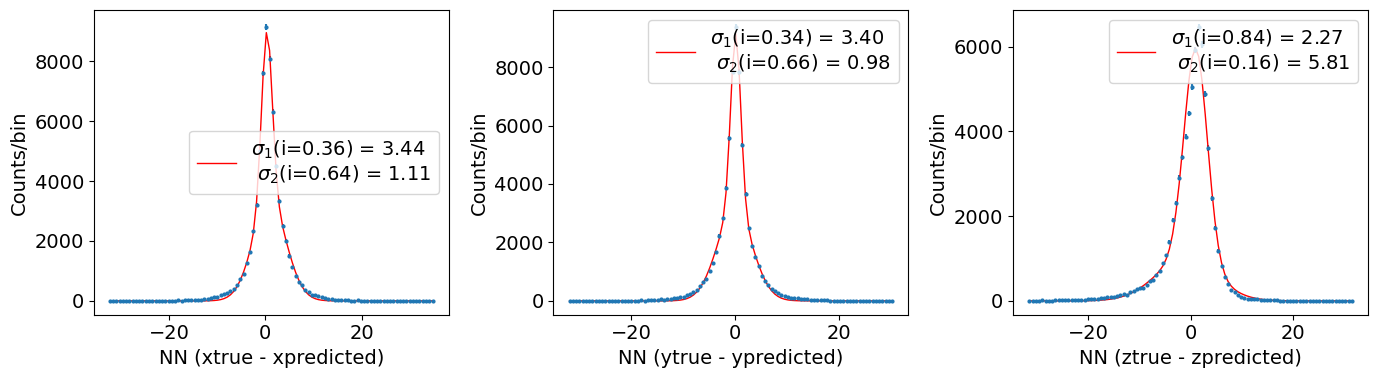

In [33]:
plotfxyz(cf2gx1, cf2gy1, cf2gz1, figsize=(14, 4))

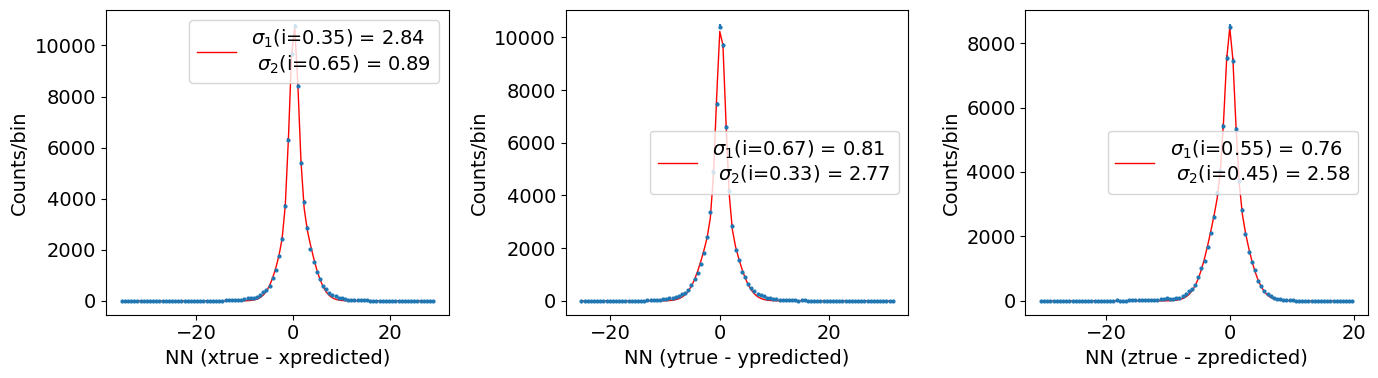

In [35]:
plotfxyz(cf2gx2, cf2gy2, cf2gz2, figsize=(14, 4))

In [36]:
tdeltasBGO = evaluate_cnn(test_loaderBGO, modelBGO, device, twoc=1)

input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 6])


In [37]:
bf2gz1, bf2gx1, bf2gy1, bf2gz2, bf2gx2, bf2gy2 = fit_tdeltas(tdeltasBGO, bins=100, twoc=1)

2g fit: mu1 = -1.00, sigma = 3.34, n1  =0.10
2g fit: mu2 = 0.25, sigma = 1.19, n1  =0.90
weighted error: = 1.40
2g fit: mu1 = -0.07, sigma = 1.85, n1  =0.25
2g fit: mu2 = -0.10, sigma = 0.63, n1  =0.75
weighted error: = 0.94
2g fit: mu1 = -0.04, sigma = 0.61, n1  =0.73
2g fit: mu2 = -0.16, sigma = 1.81, n1  =0.27
weighted error: = 0.93
2g fit: mu1 = -0.17, sigma = 1.36, n1  =0.38
2g fit: mu2 = -0.21, sigma = 0.70, n1  =0.62
weighted error: = 0.95
2g fit: mu1 = -0.07, sigma = 0.56, n1  =0.74
2g fit: mu2 = -0.09, sigma = 1.46, n1  =0.26
weighted error: = 0.79
2g fit: mu1 = 0.01, sigma = 0.54, n1  =0.72
2g fit: mu2 = -0.11, sigma = 1.42, n1  =0.28
weighted error: = 0.79


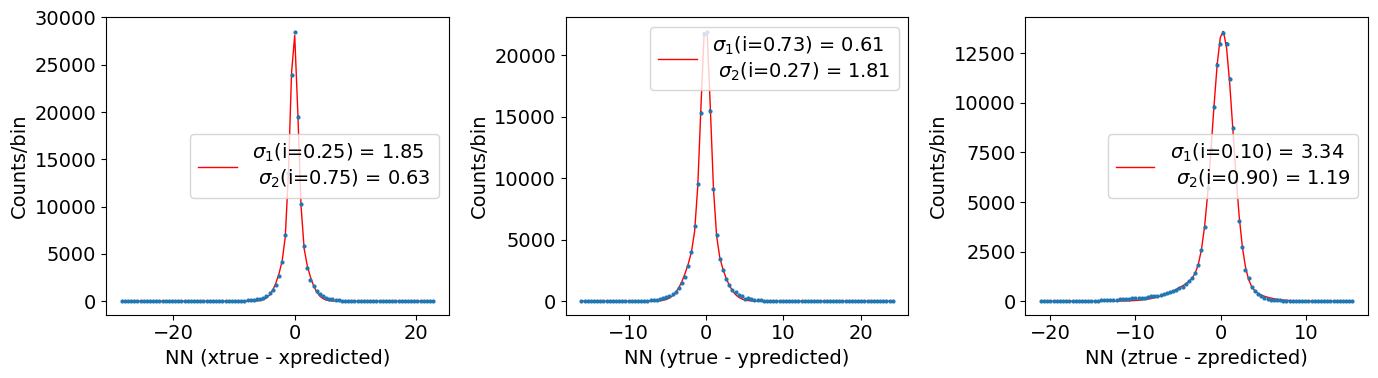

In [38]:
plotfxyz(bf2gx1, bf2gy1, bf2gz1, figsize=(14, 4))

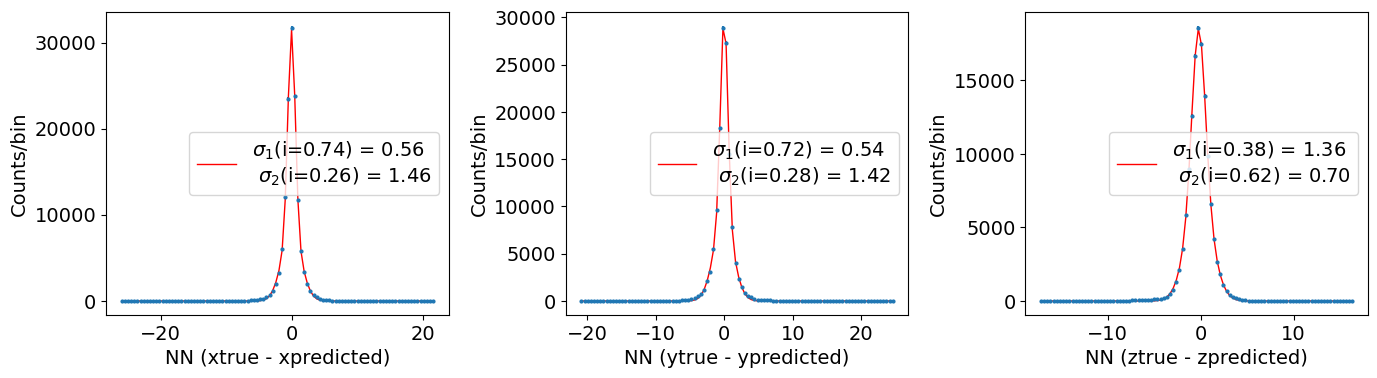

In [39]:
plotfxyz(bf2gx2, bf2gy2, bf2gz2, figsize=(14, 4))